In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [2]:
pickle_off = open ("data/return_1w.pkl", "rb")
return_1w = pickle.load(pickle_off)
return_1w

,Nifty_50_7d_return,Dow_Jons_7d_return,S&P_500_7d_return,NASDAQ_7d_return,BRENT_7d_return,BOND_10Y_7d_return,Gold_7d_return,Inr_Usd_7d_return,Dollar_Index_7d_return,sgx_7d_return,indiavix_7d_return
Date,,,,,,,,,,,
19-03-08,-39.396863,-0.896962,-0.416453,1.081556,-1.582060,0.295158,-3.253756,-1.673416,-0.790058,-27.944467,-1.643927
24-03-08,-0.950854,-4.721039,-2.914190,-7.890962,-2.230279,-0.921134,-13.056622,-2.221555,-1.636320,-1.121973,-1.810451
26-03-08,-2.168034,0.903815,18.927910,18.143736,-1.951473,-2.505928,-2.611166,-6.275383,-1.033381,-2.615742,3.299590
27-03-08,-1.958486,-1.375168,-1.489815,0.000064,-2.801153,-1.596464,-2.821636,8.957612,-1.053891,-2.008395,-1.093939
28-03-08,-2.315327,-12.043615,-2.636124,-2.533638,-1.579831,-1.890439,-0.571583,-4.350729,0.775589,-2.547021,-1.704975
...,...,...,...,...,...,...,...,...,...,...,...
29-03-23,-1.391961,3.398585,0.993800,0.064386,-0.490734,7.231247,-0.054475,-2.371659,-1.128921,-0.309082,-0.127033
31-03-23,2.081434,-9.308821,-14.932475,5.159787,2.139210,-1.517457,-1.319113,1.244808,-0.989225,-6.471258,0.007460
03-04-23,-3.949314,2.588704,1.785985,0.858414,3.788250,-4.348153,-0.854562,-0.773857,0.755773,-56.891259,-6.444835


In [3]:
'''# Add lagged returns as features
return_1w['Nifty_50_7d_return'] = return_1w['Nifty_50_7d_return'].shift(1)
return_1w['Dow_Jons_7d_return_lag1'] = return_1w['Dow_Jons_7d_return'].shift(1)
return_1w = return_1w.dropna()
return_1w['return_squared'] = return_1w['Nifty_50_7d_return'] ** 2
return_1w['return_lag_interaction'] = return_1w['Nifty_50_7d_return'] * return_1w['Dow_Jons_7d_return_lag1']
'''# Detect and remove outliers using IQR
q1 = return_1w['Nifty_50_7d_return'].quantile(0.25)
q3 = return_1w['Nifty_50_7d_return'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
return_1w = return_1w[(return_1w['Nifty_50_7d_return'] >= lower_bound) & (return_1w['Nifty_50_7d_return'] <= upper_bound)]
np.random.seed(42)

In [4]:
# Display the cleaned data
print("Cleaned data:")
print(return_1w.head())

Cleaned data:
          Nifty_50_7d_return  Dow_Jons_7d_return  S&P_500_7d_return  \
Date                                                                  
24-03-08           -0.950854           -4.721039          -2.914190   
26-03-08           -2.168034            0.903815          18.927910   
27-03-08           -1.958486           -1.375168          -1.489815   
28-03-08           -2.315327          -12.043615          -2.636124   
02-04-08           -1.910937           -0.874845          -0.786536   

          NASDAQ_7d_return  BRENT_7d_return  BOND_10Y_7d_return  \
Date                                                              
24-03-08         -7.890962        -2.230279           -0.921134   
26-03-08         18.143736        -1.951473           -2.505928   
27-03-08          0.000064        -2.801153           -1.596464   
28-03-08         -2.533638        -1.579831           -1.890439   
02-04-08         -0.850402        -1.593813            0.255627   

          Gold_7d_

In [5]:
# Display the statistics of the cleaned data
print("Statistics of the cleaned data:")
print(return_1w.describe())

Statistics of the cleaned data:
       Nifty_50_7d_return  Dow_Jons_7d_return  S&P_500_7d_return  \
count         2928.000000         2928.000000        2928.000000   
mean            -1.044088           -1.453623          -1.714326   
std              1.426273           36.237975          34.711348   
min             -5.167847        -1050.464999       -1291.437199   
25%             -1.850215           -1.990526          -2.055579   
50%             -0.990898           -0.944202          -0.967041   
75%             -0.262515           -0.120358          -0.149209   
max              3.000790          753.129457         742.877303   

       NASDAQ_7d_return  BRENT_7d_return  BOND_10Y_7d_return  Gold_7d_return  \
count       2928.000000      2928.000000         2928.000000     2928.000000   
mean          -3.112856        -0.708902           -1.049381       -0.406712   
std           89.201518        16.886647           11.648491       17.863622   
min        -4518.901188      -307.4

In [6]:
# Correlation analysis
corr_matrix_1w = return_1w.corr()
nifty_corr_1w = pd.DataFrame(return_1w.corr()['Nifty_50_7d_return'].sort_values())
nifty_corr_1w

,Nifty_50_7d_return
NASDAQ_7d_return,-0.020666
Gold_7d_return,-0.009655
Dollar_Index_7d_return,-0.007961
BRENT_7d_return,-0.005387
BOND_10Y_7d_return,0.002980
Dow_Jons_7d_return,0.010376
indiavix_7d_return,0.015210
S&P_500_7d_return,0.016977
Inr_Usd_7d_return,0.020768
sgx_7d_return,0.400915


<Axes: >

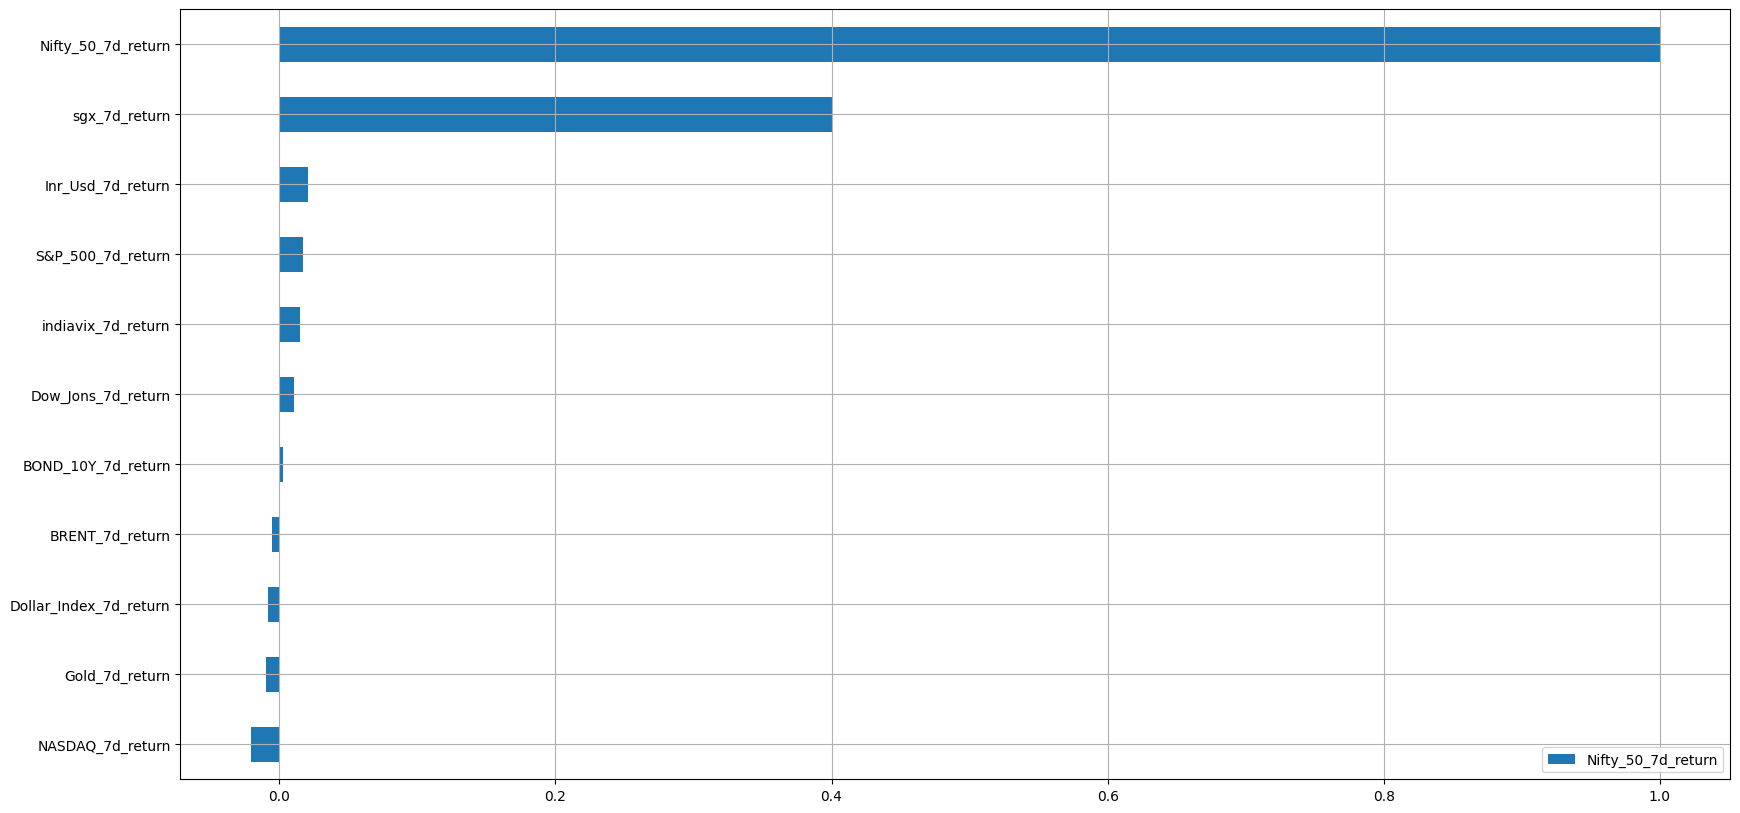

In [7]:
filter = np.abs(nifty_corr_1w)  # this creates a float64 array
mask = filter >= -1  # this creates a boolean mask based on the condition
nifty_corr_1w[mask].plot.barh(figsize=(20,10), grid=True)  # use the boolean mask to index the DataFrame

In [8]:
# Feature selection using mutual information
selector = SelectKBest(score_func=mutual_info_regression, k='all')
X = return_1w.drop(columns='Nifty_50_7d_return')
y = return_1w['Nifty_50_7d_return']
X_new = selector.fit_transform(X, y)
print('Selected features:', X.columns[selector.get_support()])

Selected features: Index(['Dow_Jons_7d_return', 'S&P_500_7d_return', 'NASDAQ_7d_return',
       'BRENT_7d_return', 'BOND_10Y_7d_return', 'Gold_7d_return',
       'Inr_Usd_7d_return', 'Dollar_Index_7d_return', 'sgx_7d_return',
       'indiavix_7d_return'],
      dtype='object')


In [9]:
# Feature Scaling
scaler = StandardScaler()
X = return_1w.drop(columns='Nifty_50_7d_return')
y = return_1w['Nifty_50_7d_return']
X = scaler.fit_transform(X_new)
y = y.astype('float32')
print(X[-5:])
print(y[-5:])

[[ 2.45234533e-02  2.82004616e-02  2.57501885e-02 -5.74588772e-02
  -1.15611785e-01 -5.46893478e-02 -2.80085835e-02  1.53506871e-01
   8.61328329e-02  9.03683795e-02]
 [ 1.33015166e-03  9.91599324e-03  2.00879065e-02 -1.12456687e-01
   1.17934718e-01  2.63553714e-02 -1.45130761e-01  2.71892264e-01
   9.44089919e-01  1.89856020e-03]
 [ 1.33921290e-01  7.80318036e-02  3.56247851e-02  1.29217920e-02
   7.10996992e-01  1.97214821e-02 -7.70737431e-02  2.42851220e-03
   1.22834486e-01  3.03858580e-02]
 [-2.16804072e-01 -3.80866979e-01  9.27568959e-02  1.68689408e-01
  -4.01902894e-02 -5.10846194e-02  9.41576345e-02  1.70291878e-02
  -1.14828958e+00  3.46929510e-02]
 [ 1.11568531e-01  1.00857777e-01  4.45278074e-02  2.66359629e-01
  -2.83241459e-01 -2.50747683e-02 -1.42148462e-03  1.99412112e-01
  -1.15488497e+01 -1.71938935e-01]]
Date
27-03-23   -0.983559
28-03-23   -3.417726
29-03-23   -1.391961
31-03-23    2.081434
03-04-23   -3.949314
Name: Nifty_50_7d_return, dtype: float32


Data Cleaning And Transformation Completed

Model Building for Features Importance

In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,  random_state=42)

In [11]:
# Define regression models
dtr = DecisionTreeRegressor(max_depth=5)
rfr = RandomForestRegressor(n_estimators=50, random_state=2)
etr = ExtraTreesRegressor(n_estimators=50, random_state=2)
gbr = GradientBoostingRegressor(n_estimators=50, random_state=2)
xgbr = XGBRegressor(n_estimators=50, random_state=2)

In [12]:
regressors = {
    'DTR': dtr,
    'RFR': rfr,
    'ETR': etr,
    'GBR': gbr,
    'XGBR': xgbr
}

In [13]:
def train_regressor(regressor, X_train, y_train, X_test, y_test):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [14]:
mse_scores = []
r2_scores = []
for name, regressor in regressors.items():
    current_mse, current_r2 = train_regressor(regressor, X_train, y_train, X_test, y_test)
    print(f"For {name}:")
    print(f"MSE: {current_mse:.4f}")
    print(f"R2: {current_r2:.4f}\n")
    mse_scores.append(current_mse)
    r2_scores.append(current_r2)

For DTR:
MSE: 0.4518
R2: 0.8115

For RFR:
MSE: 0.4062
R2: 0.8305

For ETR:
MSE: 0.4086
R2: 0.8295

For GBR:
MSE: 0.4118
R2: 0.8282

For XGBR:
MSE: 0.4716
R2: 0.8032



In [15]:
scaler = StandardScaler()
# Find the index of the model with the lowest MSE score
best_model_index = np.argmin(mse_scores)
# Get the name of the best model
best_model_name = list(regressors.keys())[best_model_index]
# Print the name of the best model
print(f"The best model is {best_model_name} with an MSE of {mse_scores[best_model_index]:.4f}.")
# Train the best model on the full dataset
best_model = regressors[best_model_name]
best_model.fit(scaler.fit_transform(X), y)

The best model is RFR with an MSE of 0.4062.


RandomForestRegressor(n_estimators=50, random_state=2)

The best model is XGBR with an MSE of 0.0435.

In [16]:
y_pred = xgbr.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df

,Actual,Predicted
Date,,
30-07-20,-1.228173,-1.301457
05-05-09,1.614979,1.921314
03-03-20,0.609348,1.585753
25-04-17,-3.662357,-3.112460
16-01-14,-3.875739,-3.104900
...,...,...
30-10-20,-2.690874,-2.508668
20-04-10,2.839383,1.347448
24-07-17,-0.803408,-0.922901


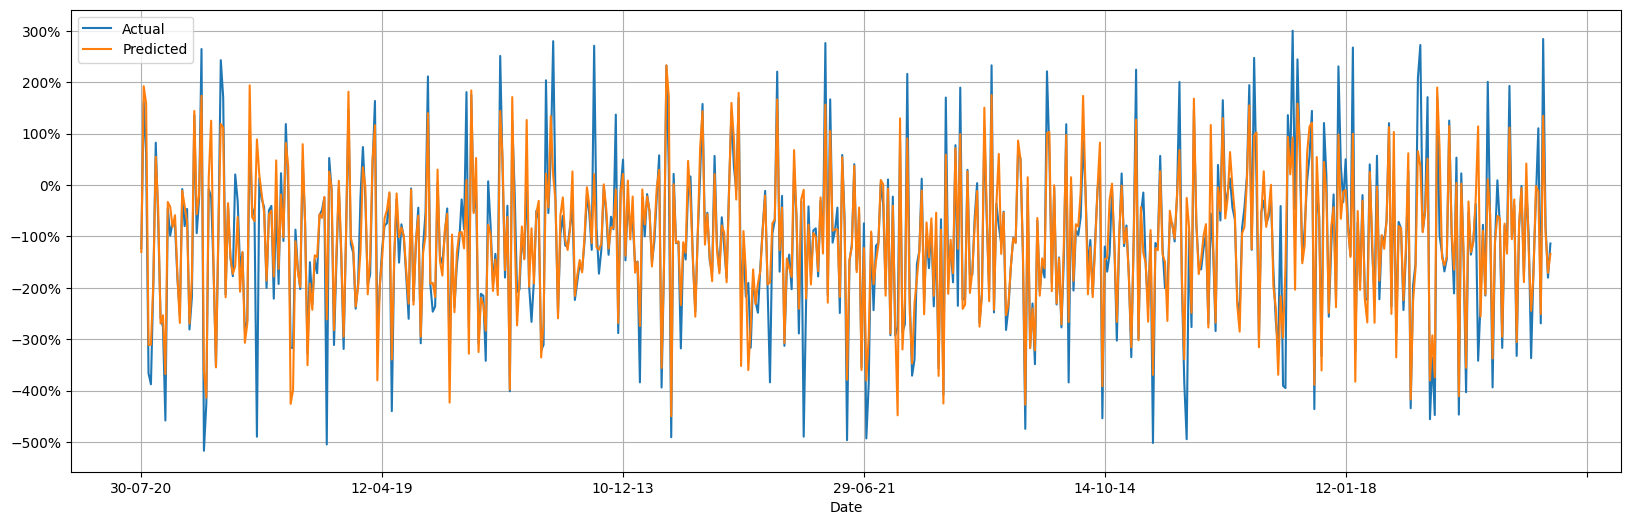

In [17]:
ax = df.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

C:\Users\Harsh\AppData\Local\Temp\ipykernel_4628\3094767840.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred)


<Axes: xlabel='Nifty_50_7d_return', ylabel='Density'>

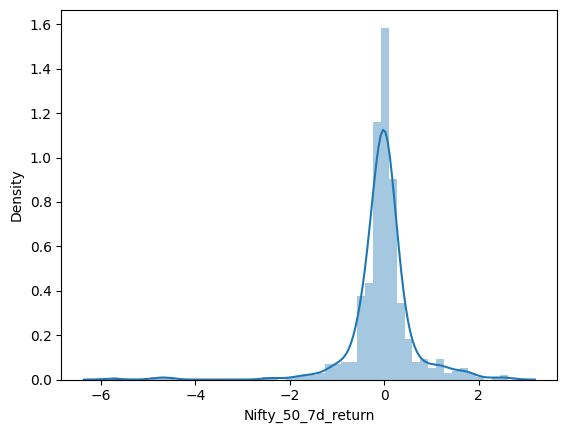

In [18]:
sns.distplot(y_test-y_pred)

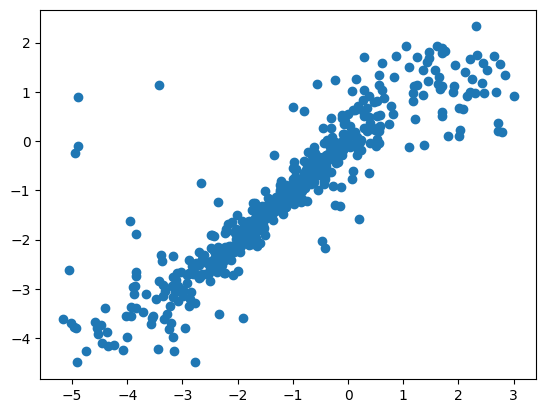

In [19]:
plt.scatter(y_test,y_pred)